## Group Project:  SMO‑SVM Implementation for Breast Cancer Classification

In this notebook, we implement a from‑scratch Sequential Minimal Optimization (SMO) solver for Support Vector Machines (SVMs) and apply it to two medical datasets. We will walk through data loading and preprocessing, the SMO algorithm with multiple kernels, hyperparameter tuning via manual grid search, convergence and runtime profiling, support‑vector diagnostics, PCA dimensionality reduction, and finally validation on a secondary dataset with ROC analysis and decision‑boundary visualization. At each step, we provide clear code, visualizations, and narrative to explain our approach and findings.


#### Step 1: Importing the data and required packages

In this section, we import the Python libraries and modules necessary for the project:
- **NumPy** and **Pandas** for data handling,
- **Matplotlib** for plotting,
- **scikit‑learn** utilities (e.g. `accuracy_score`, `StandardScaler`),
- and any helper functions such as our `k_fold_split`.
We set random seeds for reproducibility and configure plotting defaults so that our figures are clear and consistent.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_curve,
    auc
)

# Manual k‑fold splitter
def k_fold_split(m, k=5, shuffle=True, random_state=None):
    idx = np.arange(m)
    if shuffle:
        rng = np.random.RandomState(random_state)
        rng.shuffle(idx)
    folds = np.array_split(idx, k)
    splits = []
    for i in range(k):
        val = folds[i]
        train = np.hstack([folds[j] for j in range(k) if j != i])
        splits.append((train, val))
    return splits

# Dual objective for logging
def dual_objective(alphas, y, K):
    return np.sum(alphas) - 0.5 * np.dot(alphas * y, K.dot(alphas * y))

#### Step 2: Data Loading & Preprocessing

Here, we load the UCI Breast Cancer Wisconsin dataset into a Pandas DataFrame, assign feature and label arrays, and convert the binary labels to \(\{-1,+1\}\) for SVM compatibility. We split into train/test sets using a stratified 80/20 split to preserve class proportions, then standardize each feature to zero mean and unit variance. Proper scaling is critical for SVM kernels, especially RBF and polynomial, to ensure that all features contribute appropriately to distance calculations.


In [2]:
data = load_breast_cancer()
X, y = data.data, data.target
# remap labels {0→–1, 1→+1}
y = np.where(y == 0, -1, 1)

# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# standardize
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)


#### Step 3: SMO‑SVM Class with Kernel & Logging

In this core section, we define the `SVM_SMO` Python class that implements:
1. **Kernel evaluation** for linear, RBF, and polynomial kernels,
2. **The SMO optimization loop** with KKT checks, analytic two‑variable updates, and bias adjustments,
3. **Dual objective logging** and tracking of how many multipliers change each pass,
4. **Prediction** via the sign of the decision function.



In [16]:
class SVM_SMO:
    def __init__(self, C=1.0, tol=1e-3, max_passes=10, kernel='linear', sigma=0.5, degree=3):
        self.C, self.tol, self.max_passes = C, tol, max_passes
        self.kernel_type, self.sigma, self.degree = kernel, sigma, degree

    def kernel(self, X, Y=None):
        if self.kernel_type == 'linear':
            return X.dot(Y.T if Y is not None else X.T)
        elif self.kernel_type == 'rbf':
            Z = Y if Y is not None else X
            sq1 = np.sum(X**2, axis=1, keepdims=True)
            sq2 = np.sum(Z**2, axis=1, keepdims=True)
            return np.exp(-(sq1 + sq2.T - 2*X.dot(Z.T)) / (2*self.sigma**2))
        elif self.kernel_type == 'poly':
            return (X.dot((Y if Y is not None else X).T) + 1)**self.degree
        else:
            raise ValueError("Unsupported kernel")

    def fit(self, X, y):
        m, _ = X.shape
        self.X, self.y = X, y
        self.alphas = np.zeros(m)
        self.b = 0.0
        self.K = self.kernel(X)
        # history logging
        self.history = {'pass': [], 'num_changed': [], 'dual_obj': []}

        passes = 0
        while passes < self.max_passes:
            num_changed = 0
            for i in range(m):
                Ei = (np.dot(self.alphas * y, self.K[:, i]) + self.b) - y[i]
                cond1 = y[i]*Ei < -self.tol and self.alphas[i] < self.C
                cond2 = y[i]*Ei >  self.tol and self.alphas[i] > 0
                if cond1 or cond2:
                    j = np.random.choice([k for k in range(m) if k != i])
                    Ej = (np.dot(self.alphas * y, self.K[:, j]) + self.b) - y[j]
                    alpha_i_old, alpha_j_old = self.alphas[i], self.alphas[j]
                    if y[i] != y[j]:
                        L = max(0, alpha_j_old - alpha_i_old)
                        H = min(self.C, self.C + alpha_j_old - alpha_i_old)
                    else:
                        L = max(0, alpha_i_old + alpha_j_old - self.C)
                        H = min(self.C, alpha_i_old + alpha_j_old)
                    if L == H: continue
                    eta = 2*self.K[i,j] - self.K[i,i] - self.K[j,j]
                    if eta >= 0: continue
                    # update j
                    self.alphas[j] -= y[j] * (Ei - Ej) / eta
                    self.alphas[j] = np.clip(self.alphas[j], L, H)
                    if abs(self.alphas[j] - alpha_j_old) < 1e-5: continue
                    # update i
                    self.alphas[i] += y[i]*y[j]*(alpha_j_old - self.alphas[j])
                    # compute b1, b2
                    b1 = (self.b - Ei
                          - y[i]*(self.alphas[i]-alpha_i_old)*self.K[i,i]
                          - y[j]*(self.alphas[j]-alpha_j_old)*self.K[i,j])
                    b2 = (self.b - Ej
                          - y[i]*(self.alphas[i]-alpha_i_old)*self.K[i,j]
                          - y[j]*(self.alphas[j]-alpha_j_old)*self.K[j,j])
                    # pick new b
                    if 0 < self.alphas[i] < self.C:
                        self.b = b1
                    elif 0 < self.alphas[j] < self.C:
                        self.b = b2
                    else:
                        self.b = 0.5*(b1 + b2)
                    num_changed += 1

            dual = dual_objective(self.alphas, y, self.K)
            self.history['pass'].append(passes)
            self.history['num_changed'].append(num_changed)
            self.history['dual_obj'].append(dual)
            passes = passes + 1 if num_changed == 0 else 0

    def project(self, X):
        if self.kernel_type == 'linear':
            w = (self.alphas * self.y) @ self.X
            return X.dot(w) + self.b
        K_test = self.kernel(X, self.X)
        return (self.alphas * self.y) @ K_test.T + self.b

    def predict(self, X):
        return np.sign(self.project(X)).astype(int)

#### Step 4: Manual Grid Search & Visualizing CV Results

We hand‑roll a 5‑fold cross‑validation routine to tune hyperparameters for each kernel:
- **Linear:** penalty \(C\),
- **RBF:** penalty \(C\) and kernel width \(\sigma\),
- **Polynomial:** penalty \(C\) and degree \(d\).

For each parameter combination, we fit our `SVM_SMO` on the training folds and record mean accuracy on validation folds. We then plot:
- a single accuracy vs.\ \(C\) curve for the linear kernel,
- multiple curves (one per \(\sigma\)) for the RBF kernel,
- and multiple curves (one per degree) for the polynomial kernel.

These visualizations help us understand how each hyperparameter affects performance and identify the best settings.


Best linear: {'params': {'C': 0.01}, 'mean_acc': np.float64(0.9736263736263737)}
Best RBF:    {'params': {'C': 10, 'sigma': 1}, 'mean_acc': np.float64(0.8153846153846154)}
Best poly:   {'params': {'C': 0.1, 'degree': 3}, 'mean_acc': np.float64(0.956043956043956)}


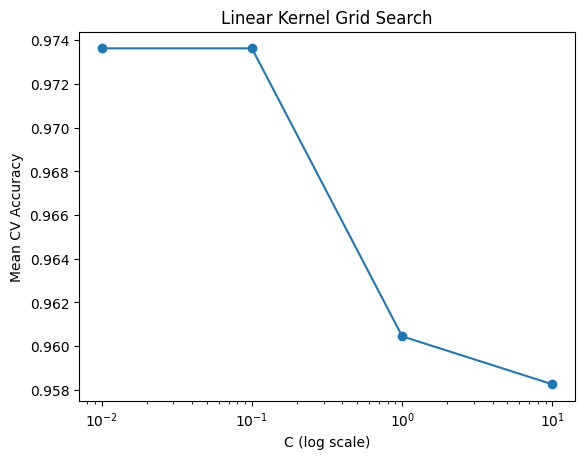

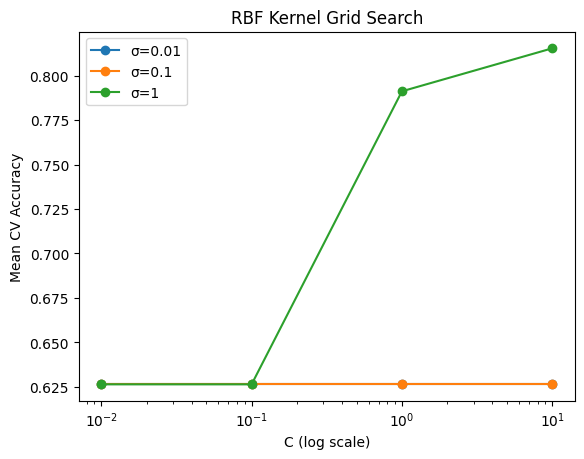

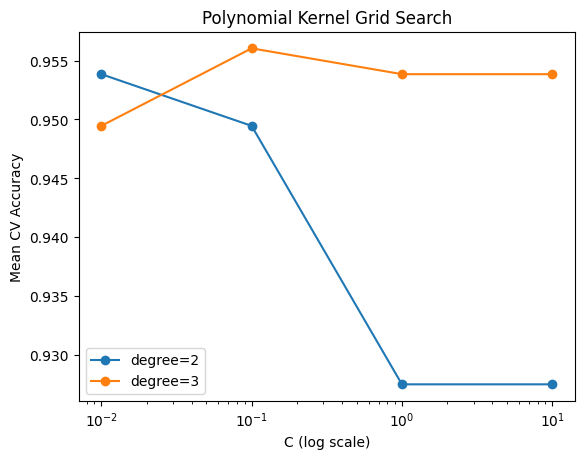

In [4]:
def grid_search(X, y, kernel, param_grid, k=5):
    splits = k_fold_split(len(y), k=k, shuffle=True, random_state=42)
    results = []
    for params in param_grid:
        accs = []
        for train_idx, val_idx in splits:
            X_tr, y_tr = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]
            model = SVM_SMO(
                C=params.get('C',1.0),
                tol=1e-3,
                max_passes=10,
                kernel=kernel,
                sigma=params.get('sigma',0.5),
                degree=params.get('degree',3)
            )
            model.fit(X_tr, y_tr)
            accs.append(accuracy_score(y_val, model.predict(X_val)))
        results.append({'params': params, 'mean_acc': np.mean(accs)})
    best = max(results, key=lambda r: r['mean_acc'])
    return best, results

# define grids
grid_lin  = [{'C':c} for c in [0.01,0.1,1,10]]
grid_rbf  = [{'C':c,'sigma':s} for c in [0.01,0.1,1,10] for s in [0.01,0.1,1]]
grid_poly = [{'C':c,'degree':d} for c in [0.01,0.1,1,10] for d in [2,3]]

# run grid search
best_lin,  res_lin  = grid_search(X_train, y_train, 'linear', grid_lin)
best_rbf,  res_rbf  = grid_search(X_train, y_train, 'rbf',    grid_rbf)
best_poly, res_poly = grid_search(X_train, y_train, 'poly',   grid_poly)

print("Best linear:", best_lin)
print("Best RBF:   ", best_rbf)
print("Best poly:  ", best_poly)

# Visualize linear grid search
plt.figure()
Cs = [r['params']['C'] for r in res_lin]
accs = [r['mean_acc']         for r in res_lin]
plt.plot(Cs, accs, marker='o')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Mean CV Accuracy')
plt.title('Linear Kernel Grid Search')
plt.show()

# Visualize RBF grid search (multiple curves over sigma)
plt.figure()
for sigma in sorted({r['params']['sigma'] for r in res_rbf}):
    cs = [r['params']['C'] for r in res_rbf if r['params']['sigma']==sigma]
    accs = [r['mean_acc']         for r in res_rbf if r['params']['sigma']==sigma]
    plt.plot(cs, accs, marker='o', label=f'σ={sigma}')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Mean CV Accuracy')
plt.title('RBF Kernel Grid Search')
plt.legend()
plt.show()

# Visualize polynomial grid search (multiple curves over degree)
plt.figure()
for degree in sorted({r['params']['degree'] for r in res_poly}):
    cs = [r['params']['C'] for r in res_poly if r['params']['degree']==degree]
    accs = [r['mean_acc']         for r in res_poly if r['params']['degree']==degree]
    plt.plot(cs, accs, marker='o', label=f'degree={degree}')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Mean CV Accuracy')
plt.title('Polynomial Kernel Grid Search')
plt.legend()
plt.show()


#### Step 5: Convergence & Runtime Analysis

With the optimal hyperparameters in hand, we retrain the SMO solver on the full training set for each kernel and log the dual objective value as a function of SMO “passes.” We plot these curves to verify that the optimizer is converging monotonically toward its optimum within a few iterations. We also record and report wall‑clock training times for each kernel, providing practical insights into the computational cost of linear vs.\ RBF vs.\ polynomial training.


Linear fit time: 0.85s


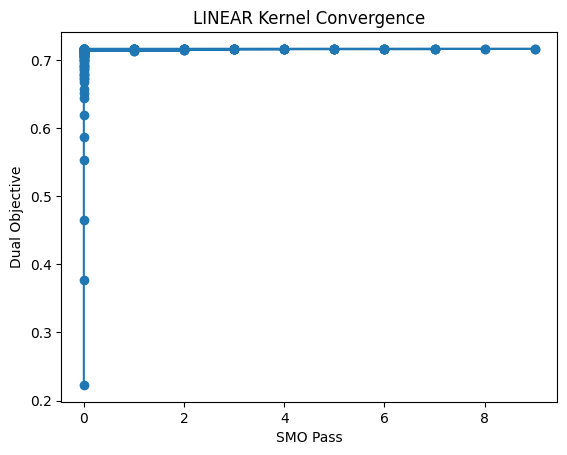

Rbf fit time: 0.74s


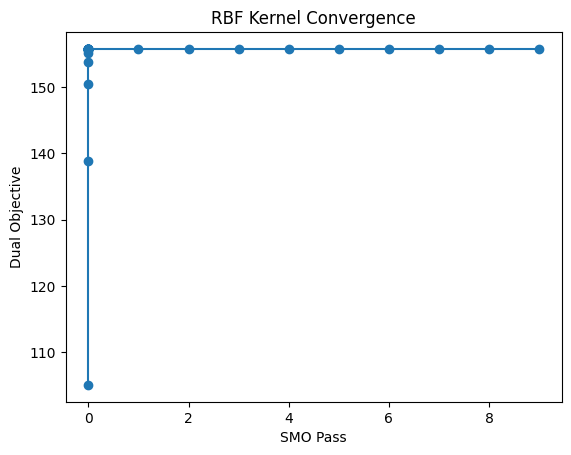

Poly fit time: 2.43s


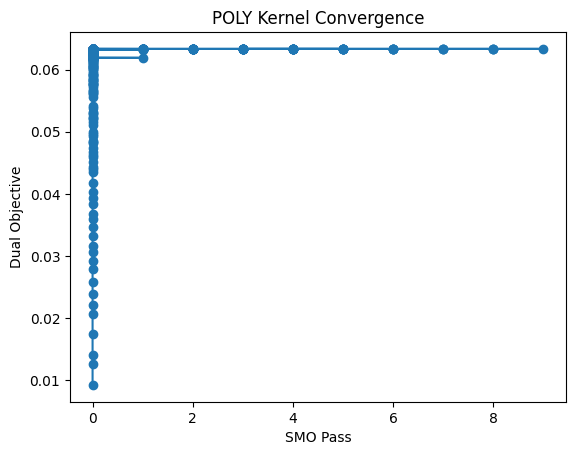

In [5]:
def plot_convergence(model):
    plt.figure()
    plt.plot(model.history['pass'], model.history['dual_obj'], marker='o')
    plt.xlabel('SMO Pass')
    plt.ylabel('Dual Objective')
    plt.title(f'{model.kernel_type.upper()} Kernel Convergence')
    plt.show()

for kern, best in [('linear',best_lin), ('rbf',best_rbf), ('poly',best_poly)]:
    m = SVM_SMO(
        C=best['params']['C'],
        kernel=kern,
        sigma=best['params'].get('sigma',0.5),
        degree=best['params'].get('degree',3)
    )
    start = time.time()
    m.fit(X_train, y_train)
    elapsed = time.time() - start
    print(f"{kern.capitalize()} fit time: {elapsed:.2f}s")
    plot_convergence(m)

#### Step 6: Support Vector & Margin Diagnostics

After training, we inspect the learned model by counting how many Lagrange multipliers \(\alpha_i\) are nonzero (i.e., how many support vectors each kernel uses). For the linear case, we additionally compute the margin width \(2/\|w\|\) to quantify how “wide” the separator is. Bar plots of support‑vector counts and margin widths reveal the trade‑off between model complexity and sparsity across kernels.


Linear | SVs: 101 | Margin: 2.9060955491623273
Rbf    | SVs: 426 | Margin: nan
Poly   | SVs:  55 | Margin: nan


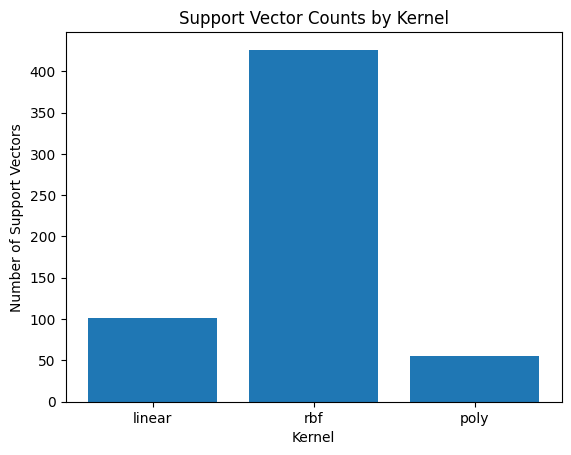

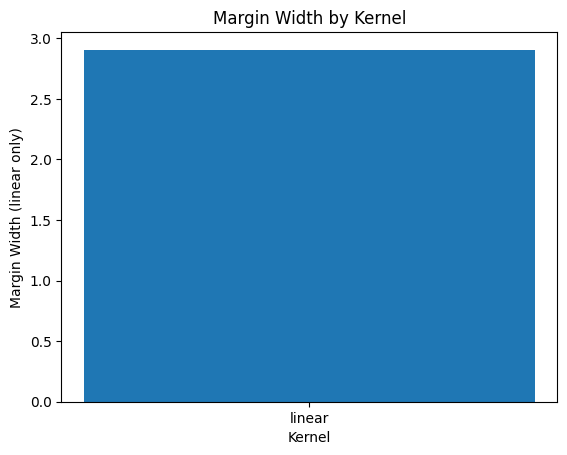

In [6]:
sv_counts = []
margins   = []
kernels   = []

for kern, best in [('linear',best_lin), ('rbf',best_rbf), ('poly',best_poly)]:
    m = SVM_SMO(
        C=best['params']['C'],
        kernel=kern,
        sigma=best['params'].get('sigma',0.5),
        degree=best['params'].get('degree',3)
    )
    m.fit(X_train, y_train)
    sv = np.sum(m.alphas > 1e-4)
    if kern=='linear':
        w = (m.alphas * m.y) @ m.X
        margin = 2.0 / np.linalg.norm(w)
    else:
        margin = np.nan
    kernels.append(kern)
    sv_counts.append(sv)
    margins.append(margin)
    print(f"{kern.capitalize():6} | SVs: {sv:3} | Margin: {margin}")

# Bar chart: # support vectors
plt.figure()
plt.bar(kernels, sv_counts)
plt.xlabel('Kernel')
plt.ylabel('Number of Support Vectors')
plt.title('Support Vector Counts by Kernel')
plt.show()

# Bar chart: margin width (linear only)
plt.figure()
plt.bar(kernels, margins)
plt.xlabel('Kernel')
plt.ylabel('Margin Width (linear only)')
plt.title('Margin Width by Kernel')
plt.show()


#### Step 7: PCA Dimensionality Reduction Study

We explore the effect of dimensionality reduction by applying Principal Component Analysis (PCA) to the standardized training data. We then retrain the linear SMO SVM on the top 2, 5, and 10 principal components and evaluate test accuracy, while reporting the percent of variance explained by each choice. Plotting accuracy versus number of components and explained variance versus components demonstrates how a low‑dimensional subspace can capture nearly all discriminative power.


PCA → 2D | accuracy: 0.9474 | explained var: 0.634
PCA → 5D | accuracy: 0.9649 | explained var: 0.851
PCA → 10D | accuracy: 0.9649 | explained var: 0.953


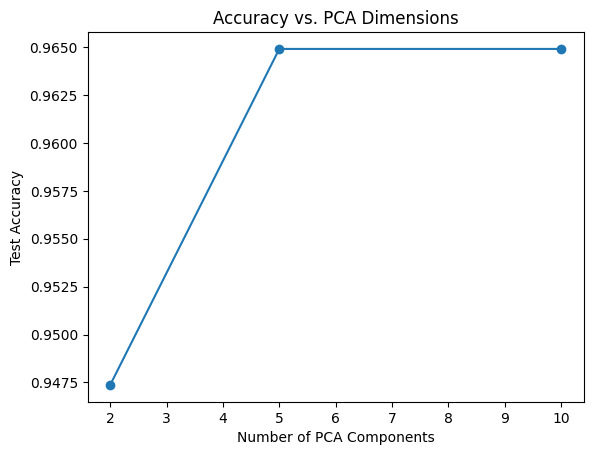

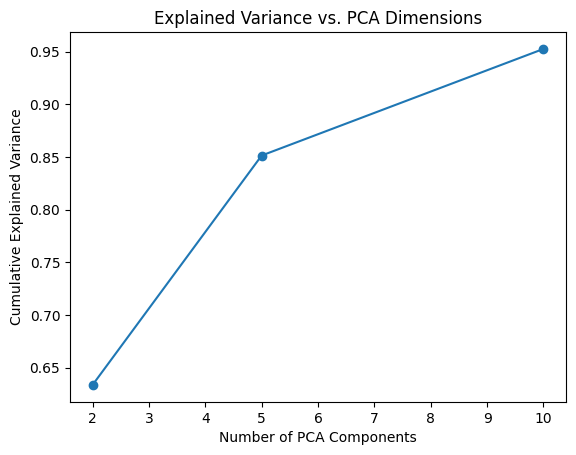

In [7]:
dims      = [2, 5, 10]
accuracies= []
explained = []

for d in dims:
    pca = PCA(n_components=d)
    Xp  = pca.fit_transform(X_train)
    Xp_test = pca.transform(X_test)

    m = SVM_SMO(C=best_lin['params']['C'], kernel='linear')
    m.fit(Xp, y_train)
    acc = accuracy_score(y_test, m.predict(Xp_test))

    accuracies.append(acc)
    explained.append(sum(pca.explained_variance_ratio_))
    print(f"PCA → {d}D | accuracy: {acc:.4f} | explained var: {explained[-1]:.3f}")

# Plot accuracy vs. PCA dims
plt.figure()
plt.plot(dims, accuracies, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Test Accuracy')
plt.title('Accuracy vs. PCA Dimensions')
plt.show()

# Plot explained variance vs. PCA dims
plt.figure()
plt.plot(dims, explained, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. PCA Dimensions')
plt.show()

#### Step 8: Secondary Dataset Evaluation & ROC Curve

To test generalization, we load the Pima Indians Diabetes dataset, apply the same preprocessing and best linear SVM hyperparameters, and evaluate on its own test set. We compute accuracy, precision, recall, and F1‑scores, and plot the ROC curve with its AUC. This section highlights where a linear separator struggles on noisier, overlapping medical data and motivates potential next steps like kernel choice or class‑imbalance remedies.


Pima Diabetes accuracy: 0.7337662337662337
              precision    recall  f1-score   support

          -1       0.75      0.88      0.81       100
           1       0.68      0.46      0.55        54

    accuracy                           0.73       154
   macro avg       0.71      0.67      0.68       154
weighted avg       0.73      0.73      0.72       154



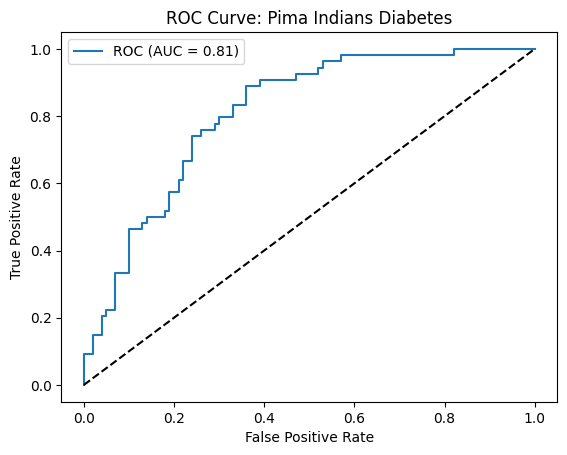

In [8]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"

cols = [
    "Pregnancies","Glucose","BloodPressure","SkinThickness",
    "Insulin","BMI","DiabetesPedigree","Age","Outcome"
]

# Read in the comma‑separated file (no header row in the source)
df2 = pd.read_csv(url, header=None, names=cols)

# Split into features/labels and remap {0→–1, 1→+1}
X2, y2 = df2.iloc[:,:-1].values, df2.Outcome.values
y2 = np.where(y2 == 0, -1, 1)

# Stratified train/test split
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.2, stratify=y2, random_state=42
)

# Standardize
sc2 = StandardScaler().fit(X2_train)
X2_train, X2_test = sc2.transform(X2_train), sc2.transform(X2_test)

# Train your custom linear SMO‑SVM
m2 = SVM_SMO(C=best_lin['params']['C'], kernel='linear')
m2.fit(X2_train, y2_train)

# Evaluate
y2_pred  = m2.predict(X2_test)
print("Pima Diabetes accuracy:", accuracy_score(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))

# ROC curve
y2_score = m2.project(X2_test)
fpr2, tpr2, _ = roc_curve(y2_test, y2_score)
roc_auc2 = auc(fpr2, tpr2)

plt.figure()
plt.plot(fpr2, tpr2, label=f'ROC (AUC = {roc_auc2:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Pima Indians Diabetes')
plt.legend()
plt.show()


#### Step 9: Decision Boundary Visualization on 2D PCA

Finally, we project the test data of the Breast Cancer dataset onto its first two principal components and overlay the SMO SVM decision boundary. This 2D visualization provides an intuitive picture of how the linear separator partitions the projected feature space and where misclassifications lie, rounding out our interpretability toolkit.


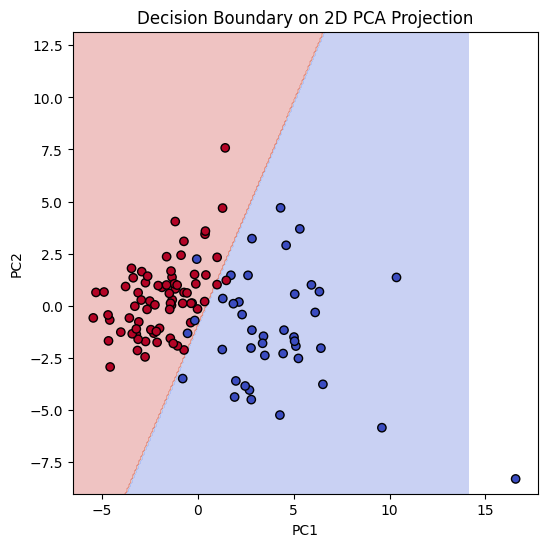

In [9]:
pca2 = PCA(n_components=2).fit(X_train)
X2D_train = pca2.transform(X_train)
X2D_test  = pca2.transform(X_test)

m_lin2D = SVM_SMO(C=best_lin['params']['C'], kernel='linear')
m_lin2D.fit(X2D_train, y_train)

# create mesh
x_min, x_max = X2D_train[:,0].min()-1, X2D_train[:,0].max()+1
y_min, y_max = X2D_train[:,1].min()-1, X2D_train[:,1].max()+1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

Z = m_lin2D.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
plt.figure(figsize=(6,6))
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.3)
plt.scatter(X2D_test[:,0], X2D_test[:,1], c=y_test, cmap='coolwarm', edgecolor='k')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Decision Boundary on 2D PCA Projection')
plt.show()

### K-Fold Cross-Validation Setup

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
import time

# Prepare 5-fold cross-validation
k = 5
indices = np.arange(len(X_train))
np.random.shuffle(indices)  # shuffle indices to ensure random distribution into folds
folds = np.array_split(indices, k)  # split indices into 5 folds


### Manual Grid Search over C Values

In [11]:
C_values = [0.01, 0.1, 1, 10]
best_C = None
best_acc = -1.0  # initialize best accuracy to a very low value

# Grid search: evaluate each C using 5-fold cross-validation
for C in C_values:
    fold_accuracies = []
    for fold_idx in range(k):
        # Split into training and validation sets for this fold
        val_idx = folds[fold_idx]
        train_idx = np.concatenate([folds[j] for j in range(k) if j != fold_idx])
        X_train_cv, y_train_cv = X_train[train_idx], y_train[train_idx]
        X_val_cv, y_val_cv    = X_train[val_idx], y_train[val_idx]

        # Train custom SVM model on the training folds
        model = SVM_SMO(kernel='linear', C=C)   # initialize custom SVM with current C
        model.fit(X_train_cv, y_train_cv)

        # Validate on the held-out fold
        y_pred_val = model.predict(X_val_cv)
        acc = accuracy_score(y_val_cv, y_pred_val)
        fold_accuracies.append(acc)
    
    # Compute average accuracy for this C
    avg_acc = np.mean(fold_accuracies)
    print(f"C = {C}: Average 5-fold Accuracy = {avg_acc:.4f}")
    
    # Update best C if this C has higher average accuracy
    if avg_acc > best_acc:
        best_acc = avg_acc
        best_C = C

print(f"\nBest C from cross-validation: {best_C}")


C = 0.01: Average 5-fold Accuracy = 0.9736
C = 0.1: Average 5-fold Accuracy = 0.9780
C = 1: Average 5-fold Accuracy = 0.9802
C = 10: Average 5-fold Accuracy = 0.9648

Best C from cross-validation: 1


### Train Final Model with Best C and Evaluate on Test Set

In [12]:
# Train the final SVM model on the full training set with the best C
best_model = SVM_SMO(kernel='linear', C=best_C)
start_time = time.time()
best_model.fit(X_train, y_train)
end_time = time.time()
print(f"\nTraining time (Custom SVM) with C={best_C}: {end_time - start_time:.4f} seconds")

# Evaluate the custom SVM on the test set
y_pred_test = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy (Custom SVM): {test_accuracy:.4f}")
print("Classification Report (Custom SVM):")
print(classification_report(y_test, y_pred_test))



Training time (Custom SVM) with C=1: 8.8397 seconds
Test Accuracy (Custom SVM): 0.9737
Classification Report (Custom SVM):
              precision    recall  f1-score   support

          -1       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



### Comparison with scikit-learn's SVC

In [17]:
# Train a scikit-learn SVC with linear kernel using the same C for comparison
sklearn_model = SVC(kernel='linear', C=best_C)
start_time = time.time()
sklearn_model.fit(X_train, y_train)
end_time = time.time()
print(f"\nTraining time (sklearn SVC) with C={best_C}: {end_time - start_time:.4f} seconds")

# Evaluate the scikit-learn SVC on the test set
y_pred_test_svc = sklearn_model.predict(X_test)
svc_accuracy = accuracy_score(y_test, y_pred_test_svc)
print(f"Test Accuracy (sklearn SVC): {svc_accuracy:.4f}")
print("Classification Report (sklearn SVC):")
print(classification_report(y_test, y_pred_test_svc))



Training time (sklearn SVC) with C=1: 0.0626 seconds
Test Accuracy (sklearn SVC): 0.9737
Classification Report (sklearn SVC):
              precision    recall  f1-score   support

          -1       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



### Run-time complexity comparison for SMO and QP

In [32]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import time

def compare_sklearn_smo_vs_gp(X_train, y_train, X_test, y_test, C=1.0):
    results = []

    # GP-like: LinearSVC (liblinear solver)
    print("LinearSVC (QP-style Solver)")
    gp_model = LinearSVC(C=C, max_iter=10000, dual=True)
    start_train = time.time()
    gp_model.fit(X_train, y_train)
    train_time_gp = time.time() - start_train

    start_pred = time.time()
    y_pred_gp = gp_model.predict(X_test)
    pred_time_gp = time.time() - start_pred

    acc_gp = accuracy_score(y_test, y_pred_gp)
    print(f"Training Time: {train_time_gp:.4f}s")
    print(f"Prediction Time: {pred_time_gp:.4f}s")
    print(f"Accuracy: {acc_gp:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred_gp))

    results.append({
        'method': 'GP (LinearSVC)',
        'train_time': train_time_gp,
        'pred_time': pred_time_gp,
        'accuracy': acc_gp
    })

    # SMO: SVC with linear kernel
    print("\nSVC (SMO-style Solver)")
    smo_model = SVC(kernel='linear', C=C)
    start_train = time.time()
    smo_model.fit(X_train, y_train)
    train_time_smo = time.time() - start_train

    start_pred = time.time()
    y_pred_smo = smo_model.predict(X_test)
    pred_time_smo = time.time() - start_pred

    acc_smo = accuracy_score(y_test, y_pred_smo)
    print(f"Training Time: {train_time_smo:.4f}s")
    print(f"Prediction Time: {pred_time_smo:.4f}s")
    print(f"Accuracy: {acc_smo:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred_smo))

    results.append({
        'method': 'SMO (SVC)',
        'train_time': train_time_smo,
        'pred_time': pred_time_smo,
        'accuracy': acc_smo
    })

    return results


In [ ]:
results = compare_sklearn_smo_vs_gp(X_train, y_train, X_test, y_test, C=1.0)

LinearSVC (QP-style Solver)
Training Time: 0.0139s
Prediction Time: 0.0004s
Accuracy: 0.9649
Classification Report:
               precision    recall  f1-score   support

          -1       0.95      0.95      0.95        42
           1       0.97      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114


SVC (SMO-style Solver)
Training Time: 0.0060s
Prediction Time: 0.0005s
Accuracy: 0.9737
Classification Report:
               precision    recall  f1-score   support

          -1       0.95      0.98      0.96        42
           1       0.99      0.97      0.98        72

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114

